In [118]:
%matplotlib inline
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from tkinter import *
from PIL import Image, ImageTk

In [119]:
img_h1 = cv.imread('img/h1.jpg')
cv.imwrite('img/h1_1.jpg', cv.resize(img_h1, (500, 500)))

True

In [120]:
e2c = lambda e, c: (c.canvasx(e.x), c.canvasy(e.y))


def print_pos(e):
    cx, cy = e2c(e, canvas)
    click = [e.y, e.x, cy, cx]
    nodes.append(click)
    i = len(nodes)
    canvas.create_text(220 + i * 62, 670, text=f"P{i}:(%d,%d)," % (e.y, e.x), font=("Arial", 10))
    print(f"Point {i}: (%d, %d) / (%d, %d)" % (e.y, e.x, cy, cx))


loc = Tk()
nodes = []

loc.geometry("950x750")
loc.title("part3")
canvas = Canvas(loc, width=950, height=800, bg='white', )
canvas.pack()

img_h1 = Image.open('img/h1_1.jpg')
img_h2 = Image.open('img/h2.jpg')
img_h1_photo = ImageTk.PhotoImage(img_h1)
img_h2_photo = ImageTk.PhotoImage(img_h2)


def modify_img():
    canvas.itemconfig(Im, image=img_h2_photo)
    canvas.itemconfig(Tx, text="You need to click 4 points on h2")


Im = canvas.create_image(0, 0, image=img_h1_photo, anchor=NW)
canvas.config(scrollregion=canvas.bbox(ALL))
Tx = canvas.create_text(200, 620, text="You need to click 4 points on h1", font=("Arial", 15))
canvas.create_text(180, 670, text="Position of points:", font=("Arial", 15))

canvas.bind("<ButtonPress-1>", print_pos)

btn = Button(loc, text='next img', command=modify_img)
btn.place(x=800, y=700)

loc.mainloop()

Point 1: (5, 5) / (2, 2)
Point 2: (499, 6) / (496, 3)
Point 3: (498, 495) / (495, 492)
Point 4: (5, 496) / (2, 493)
Point 5: (221, 11) / (218, 8)
Point 6: (579, 371) / (576, 368)
Point 7: (312, 843) / (309, 840)
Point 8: (17, 468) / (14, 465)


In [121]:
def homography(points):
    A = np.zeros([8, 9])
    for i in range(0, 4):
        h1_x = points[i][2]
        h1_y = points[i][3]
        h2_x = points[i + 4][2]
        h2_y = points[i + 4][3]
        A[2 * i][:] = [h1_x, h1_y, 1, 0, 0, 0, -h2_x * h1_x, -h2_x * h1_y, -h2_x]
        A[2 * i + 1][:] = [0, 0, 0, h1_x, h1_y, 1, -h2_y * h1_x, -h2_y * h1_y, -h2_y]

    v1, v2, vt = np.linalg.svd(A)
    res = vt[-1].reshape(3, 3)
    res = res / res[2, 2]
    return res


In [135]:
H = homography(nodes)
print("homography results:")
print(H)

homography results:
[[ 5.84661598e-01 -4.12452483e-01  2.17642247e+02]
 [ 6.36642853e-01  1.03036329e+00  4.66549834e+00]
 [-2.44922338e-04  2.14336913e-04  1.00000000e+00]]


In [123]:
image_h1 = cv.imread('img/h1_1.jpg')
image_h1 = cv.cvtColor(image_h1, cv.COLOR_BGR2RGB)

image_h2 = cv.imread('img/h2.jpg')
image_h2 = cv.cvtColor(image_h2, cv.COLOR_BGR2RGB)


def size_shape(h1, H):
    [row, col, _] = h1.shape

    lt = np.array([[0, 0, 1]])
    rt = np.array([[0, col, 1]])
    lb = np.array([[row, 0, 1]])
    rb = np.array([[row, col, 1]])

    edge = np.concatenate((lt, rt, lb, rb), axis=0).T

    T_edge = np.dot(H, edge)
    T_edge = T_edge[0:2, :] / T_edge[2, :]
    T_edge = T_edge
    print(T_edge)

    return np.max(T_edge[0, :]), np.min(T_edge[0, :]), np.max(T_edge[1, :]), np.min(T_edge[1, :])


def transfer_bilingual(h1, H):
    [max_x, min_x, max_y, min_y] = size_shape(h1, H)

    x_diff = int(round(max_x - min_x + 10))
    y_diff = int(round(max_y - min_y + 10))
    [row, col, c] = h1.shape
    h12h2 = np.zeros([x_diff + 100, y_diff + 100, c])
    print([max_x, min_x, max_y, min_y])
    for j in range(0, row):
        for k in range(0, col):
            p = np.array([[j, k, 1]]).T
            p_val = np.dot(H, p)

            x = int(round(p_val[0, 0] / p_val[2, 0]) - min_x)
            y = int(round(p_val[1, 0] / p_val[2, 0]) - min_y)

            h12h2[x, y] = h1[j, k][:]

    return h12h2.astype(int)


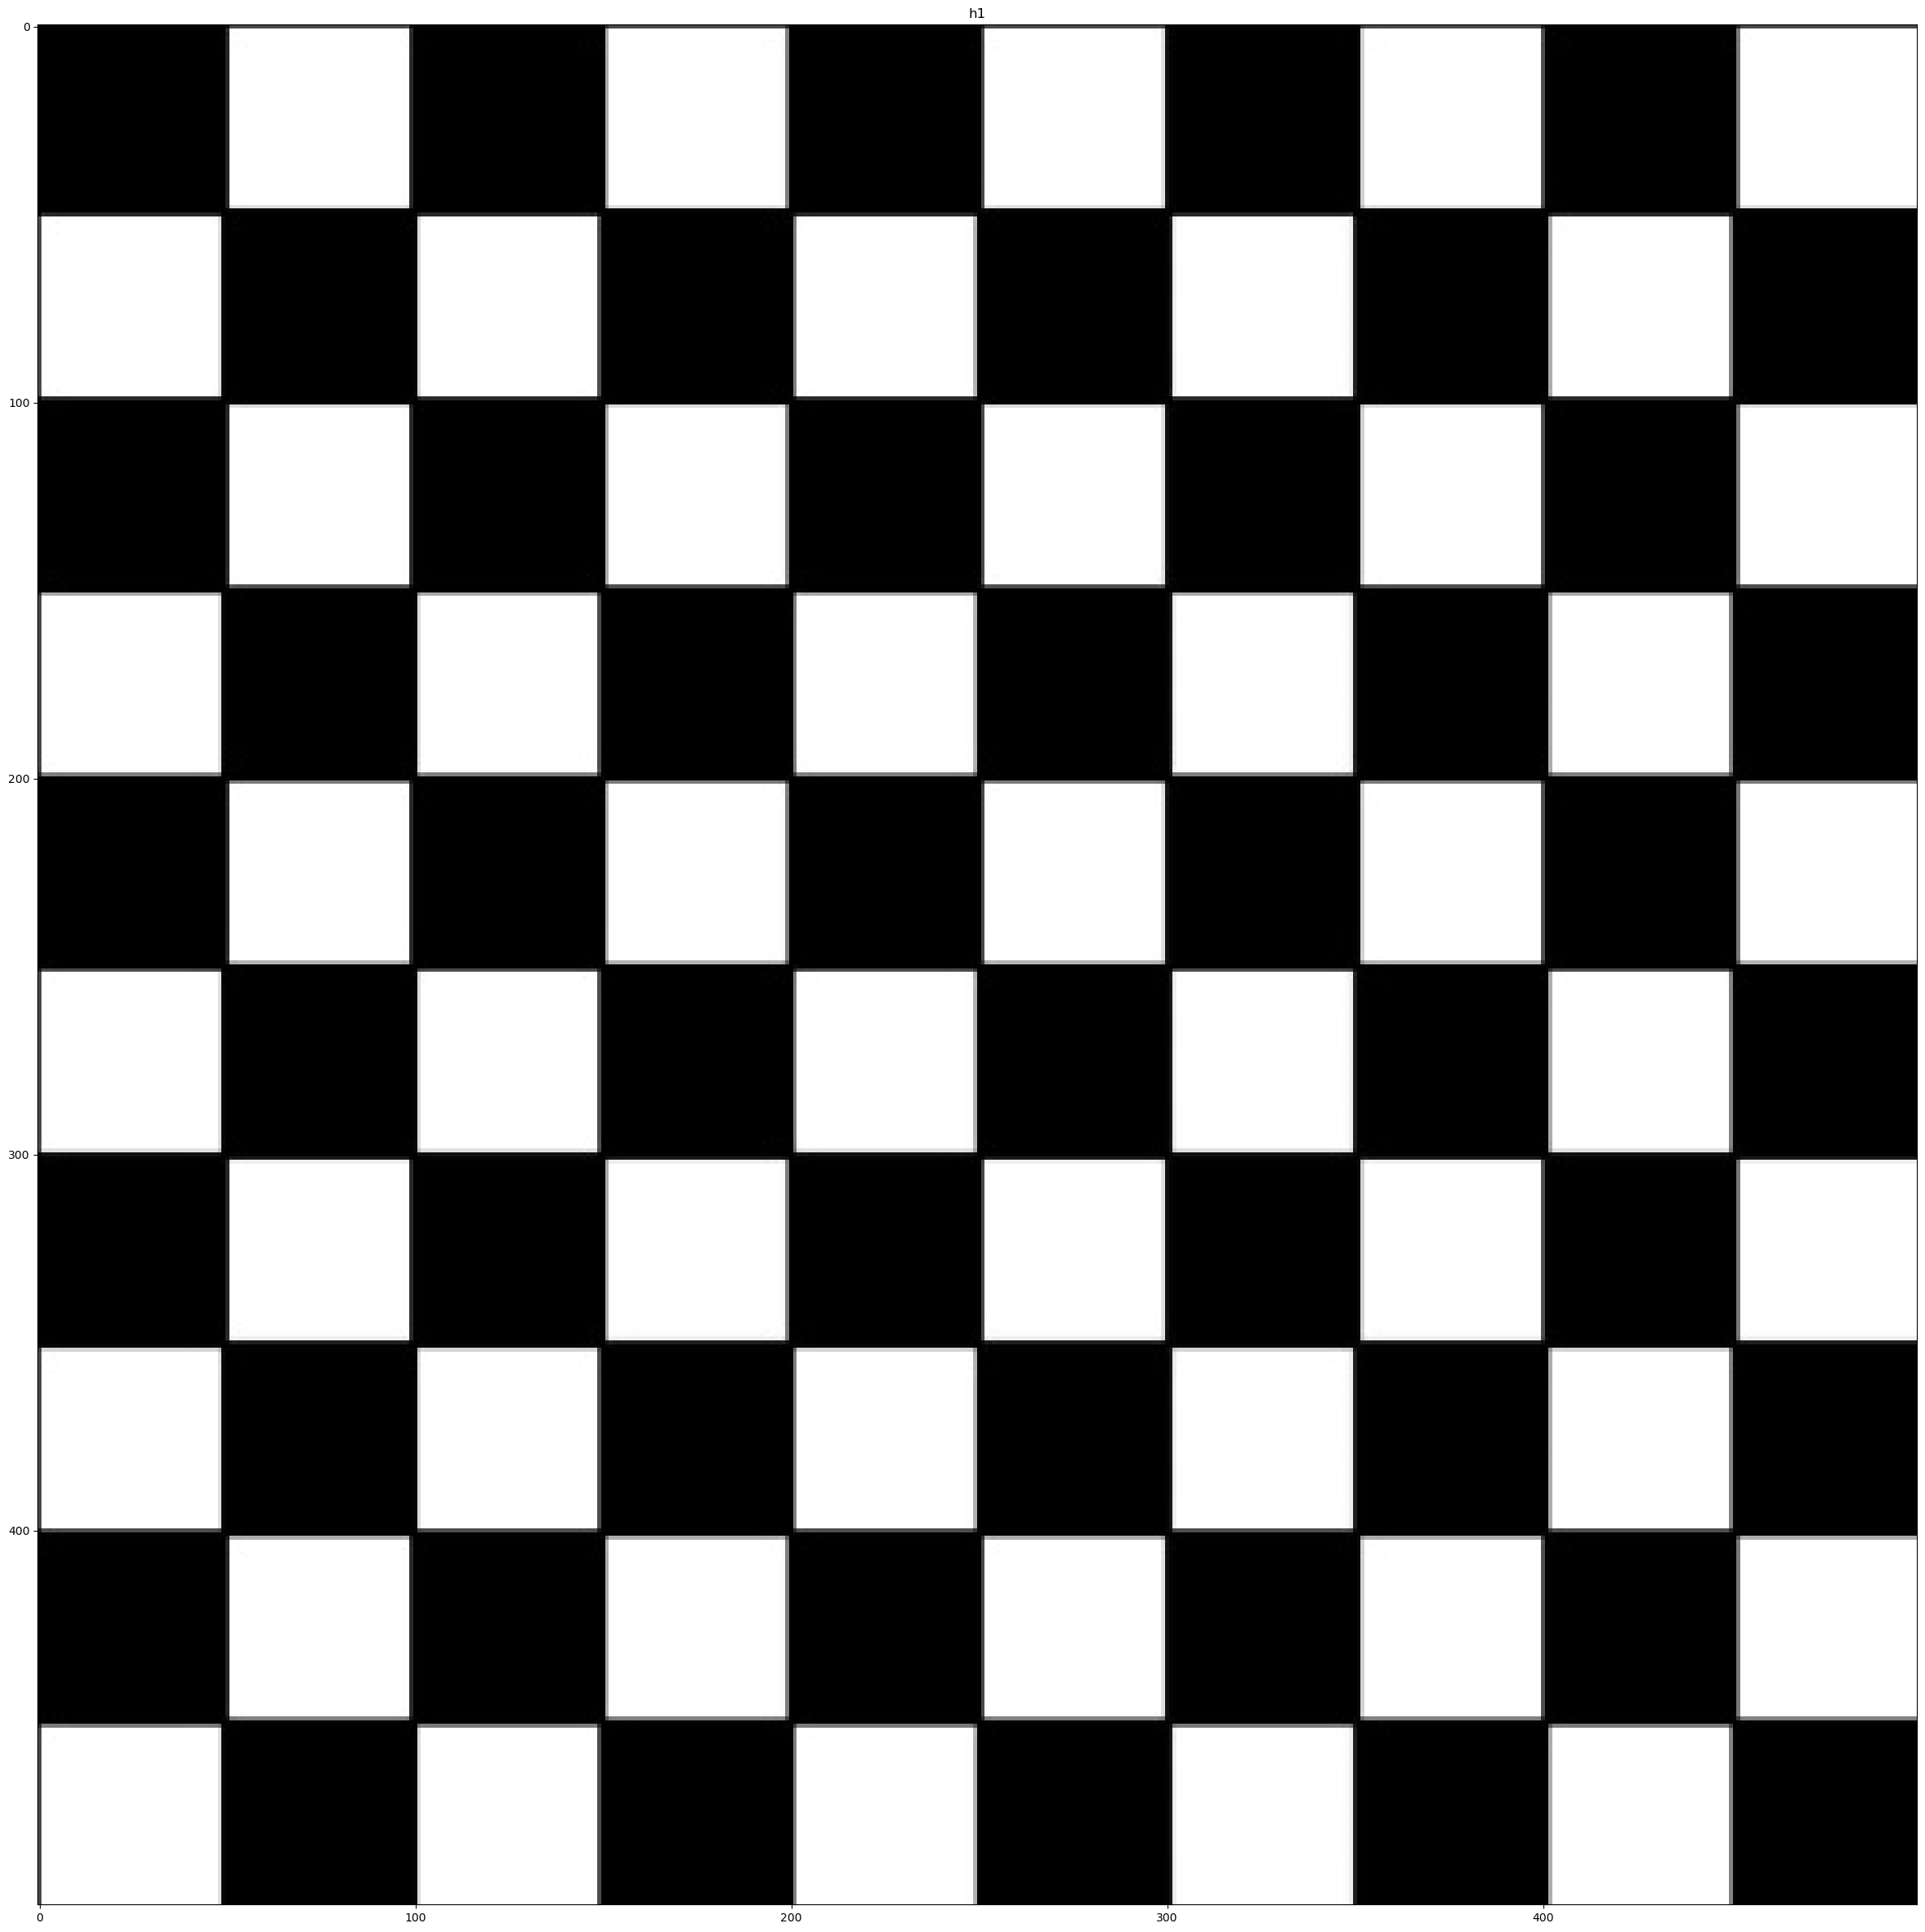

In [124]:
plt.figure(figsize=(30, 30))
plt.title('h1')
plt.imshow(image_h1)
plt.show()

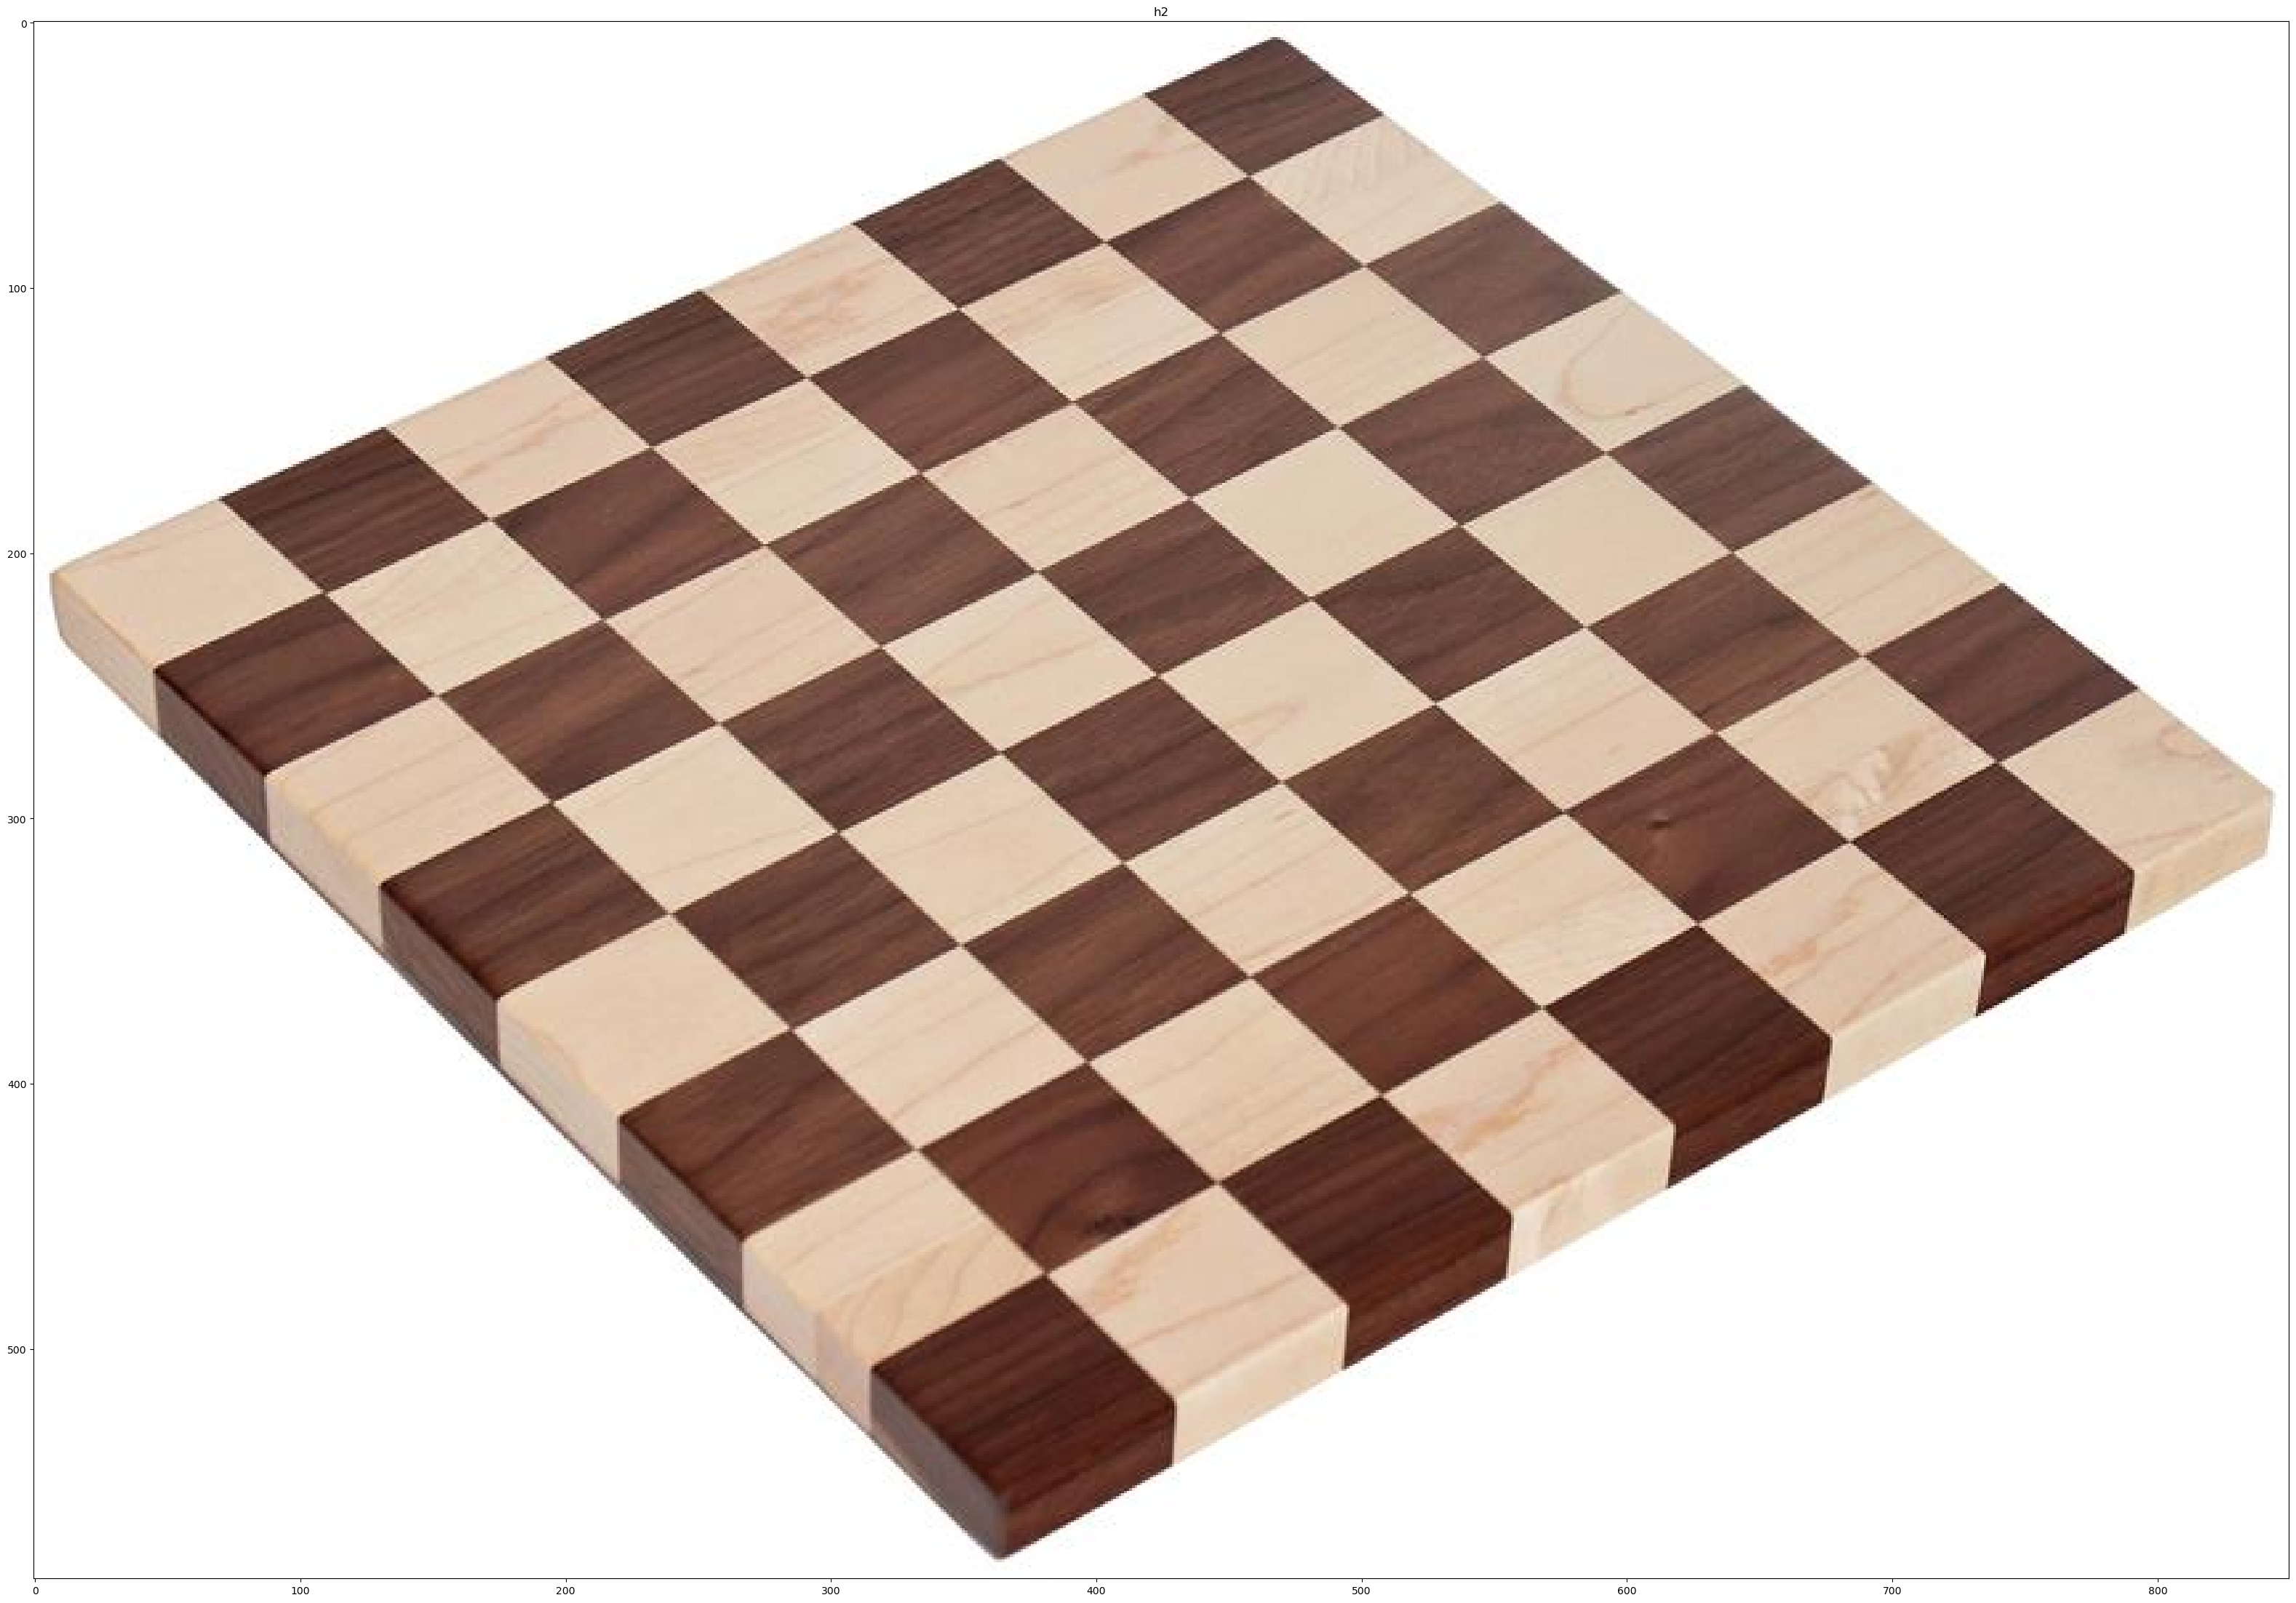

In [125]:
plt.figure(figsize=(40, 40))
plt.title('h2')
plt.imshow(image_h2)
plt.show()

[[217.64224652  10.31099188 581.14014758 308.46405626]
 [  4.66549834 469.52850051 368.05998044 851.18550713]]
[581.1401475797478, 10.310991884755266, 851.1855071258105, 4.665498339263545]


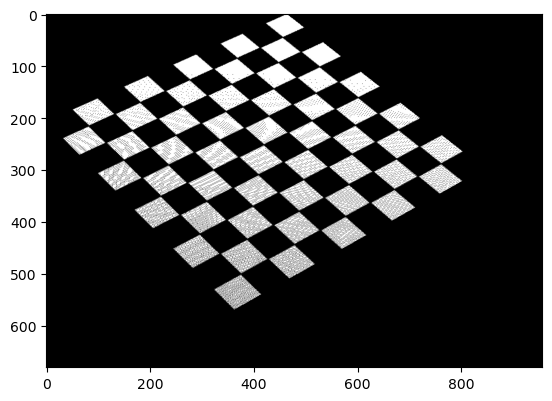

In [126]:
h12h2 = transfer_bilingual(image_h1, H)
plt.imshow(h12h2)

In [127]:
points2 = nodes[4:8] + nodes[0:4]
H2 = homography(points2)
print(H2)

Hi = np.linalg.inv(H)
print(Hi)

[[ 1.19001707e+00  5.30753642e-01 -2.61474218e+02]
 [-7.37325365e-01  7.37535201e-01  1.57032180e+02]
 [ 4.49497805e-04 -2.80875953e-05  1.00000000e+00]]
[[ 1.08410177e+00  4.83514881e-01 -2.38202182e+02]
 [-6.71701065e-01  6.71892225e-01  1.43055817e+02]
 [ 4.09491072e-04 -2.55877101e-05  9.10996823e-01]]


[[-261.47421789  194.30531126  345.81951783  716.30659704]
 [ 157.03217956  803.11093741 -218.20364157  283.17142014]]
[716.306597035438, -261.47421789373834, 803.1109374093159, -218.20364156752737]


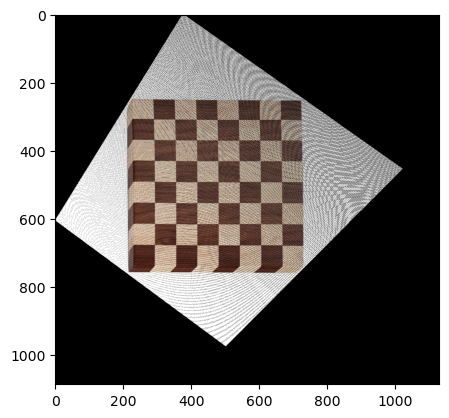

In [128]:
h22h1 = transfer_bilingual(image_h2, H2)
plt.imshow(h22h1)

In [129]:
def print_pos_1(e):
    cx, cy = e2c(e, canvas)
    click = [e.y, e.x, cy, cx]
    print("(%d, %d) / (%d, %d)" % (e.y, e.x, cy, cx))
    nodes_n.append(click)
    i = len(nodes_n)
    canvas.create_text(300 + i * 50, 750, text="(%d,%d)" % (e.y, e.x), font=("Arial", 10))


loc = Tk()
nodes_n = []

loc.geometry("1000x1000")
loc.title("part3")
canvas = Canvas(loc, bg='white', width=1080, height=1200)
canvas.pack()

img_bus = Image.open('./img/bus.jpg')
img_bus_photo = ImageTk.PhotoImage(img_bus)
Im = canvas.create_image(0, 0, image=img_bus_photo, anchor=NW)
canvas.config(scrollregion=canvas.bbox(ALL))

Tx = canvas.create_text(200, 730, text="Click 4 points: top left, top right, down left, down right",
                        font=("Arial", 15))
canvas.create_text(180, 750, text="Position of points:", font=("Arial", 15))

canvas.bind("<ButtonPress-1>", print_pos_1)

loc.mainloop()

(215, 585) / (212, 585)
(236, 797) / (233, 797)
(520, 598) / (517, 598)
(472, 801) / (469, 801)


(1500, 1000, 3)


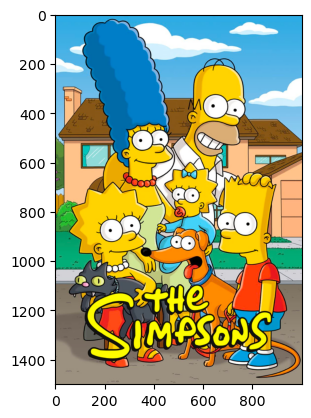

In [130]:
bus = cv.imread('./img/bus.jpg', cv.IMREAD_COLOR)
simpsons = cv.imread('./img/simpsons.jpg', cv.IMREAD_COLOR)
bus = cv.cvtColor(bus, cv.COLOR_BGR2RGB)
simpsons = cv.cvtColor(simpsons, cv.COLOR_BGR2RGB)

plt.imshow(simpsons)
print(simpsons.shape)


1000 1500
[[212.         233.         517.         469.        ]
 [584.99999997 797.         598.         801.00000002]]
[517.0000000046538, 211.99999999999997, 801.0000000159826, 584.9999999735603]


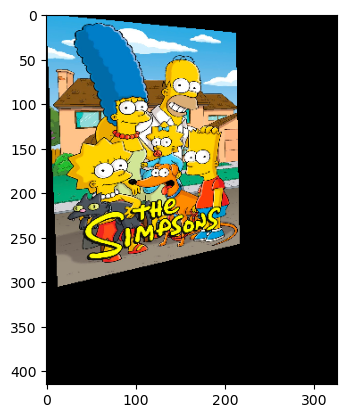

In [131]:
[row, col, c] = simpsons.shape
print(col, row)
# lt = [[0, 0, 0, 0]]
# rt = [[0, col - 1, 0, col - 1]]
# lb = [[row - 1, 0, row - 1, 0]]
# rb = [[row - 1, col - 1, row - 1, col - 1]]
# top left, top right, down left, down right
lt = [[0, 0, 0, 0]]
rt = [[0, col, 0, col]]
lb = [[row, 0, row, 0]]
rb = [[row, col, row, col]]
points_add = lt + rt + lb + rb + nodes_n

H3 = homography(points_add)
Tsimpsons = transfer_bilingual(simpsons, H3)
plt.imshow(Tsimpsons)


212 517 585 801


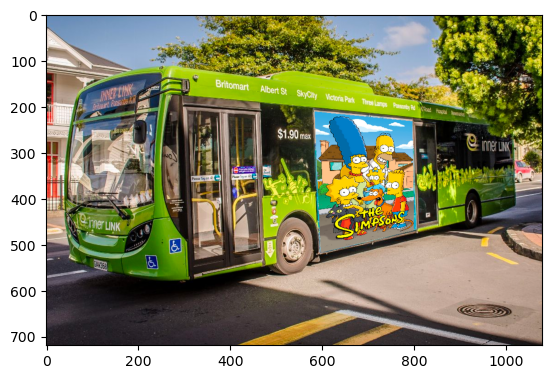

In [132]:
bus_add = cv.imread('./img/bus.jpg', cv.IMREAD_COLOR)
bus_add = cv.cvtColor(bus_add, cv.COLOR_BGR2RGB)

points_2 = np.array(nodes_n)
x_max = int(np.max(points_2[:, 2]))
x_min = int(np.min(points_2[:, 2]))
y_max = int(np.max(points_2[:, 3]))
y_min = int(np.min(points_2[:, 3]))
print(x_min, x_max, y_min, y_max)

for j in range(x_min, x_max):
    for k in range(y_min, y_max):

        x = j - x_min
        y = k - y_min
        if any(Tsimpsons[x, y] > 0):
            bus_add[j, k] = Tsimpsons[x, y][:]

plt.imshow(bus_add)
